[View in Colaboratory](https://colab.research.google.com/github/eswk22/tgs-salt-identification-challenge/blob/master/Unet_without_depth.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from tensorflow import keras
import tensorflow as tf
from skimage.transform import resize
from scipy.ndimage import gaussian_filter
from skimage import data,io,img_as_float
from skimage.morphology import reconstruction
from sklearn.model_selection import train_test_split
from skimage import io
from keras.preprocessing.image import load_img
from google.colab import files


Using TensorFlow backend.


In [0]:
!pip install -U -q PyDrive

In [0]:
 #read file from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import io
import zipfile
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1tnvXY1HveE27K1YchpOI_YG4y6wjMtwL' #-- Updated File ID for my zip
downloaded = drive.CreateFile({'id': file_id}) 

In [0]:
downloaded.GetContentFile('raw.zip') 
!unzip './/raw.zip'


In [2]:
os.listdir(os.curdir)

['datalab',
 'raw.zip',
 '.cache',
 '.config',
 '.forever',
 '.nv',
 '.keras',
 'keras.model',
 '.ipython',
 '.local',
 'raw',
 'logs']

In [0]:
raw_data_path = os.path.join(os.curdir,'raw')
def read_data():
    train_data_path = os.path.join(raw_data_path,'train.csv')
    depth_data_path = os.path.join(raw_data_path,'depths.csv')
    df_train = pd.read_csv(train_data_path,index_col='id')
    df_train.rle_mask.fillna(-1,inplace=True)
    df_depth = pd.read_csv(depth_data_path,index_col='id')
    df_train['depth'] = df_depth['z']
    return df_train

In [0]:
df = read_data()

(array([ 68., 117., 125., 165., 177., 205., 236., 241., 295., 311., 297.,
        307., 283., 281., 265., 200., 200., 130.,  47.,  50.]),
 array([ 51. ,  96.4, 141.8, 187.2, 232.6, 278. , 323.4, 368.8, 414.2,
        459.6, 505. , 550.4, 595.8, 641.2, 686.6, 732. , 777.4, 822.8,
        868.2, 913.6, 959. ]),
 <a list of 20 Patch objects>)

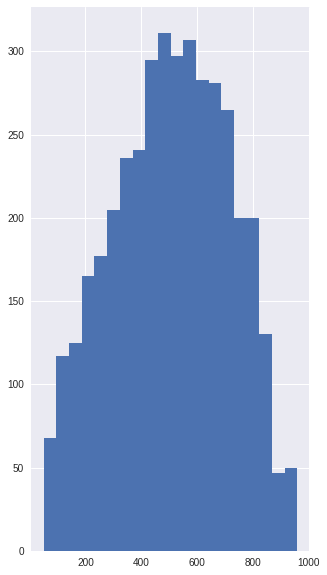

In [5]:
plt.rcParams["figure.figsize"] = (5,10)
plt.hist(df['depth'].values,bins=20)

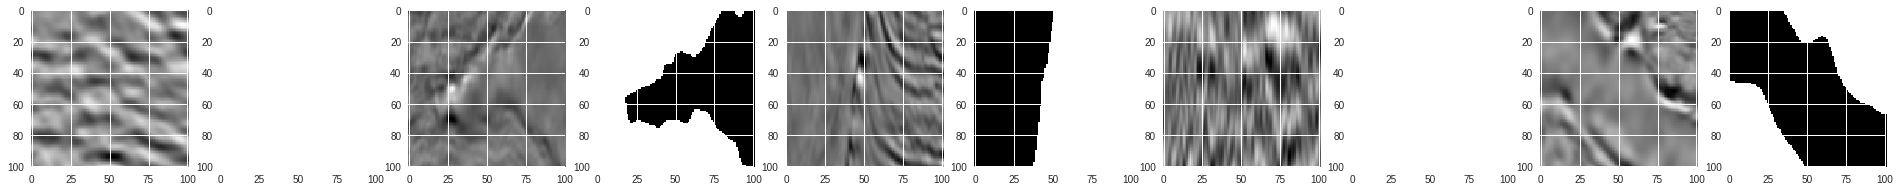

In [6]:
ids=['000e218f21','0b73b427d1','0ba541766e','0a7e067255','0a1742c740']
train_images_path = os.path.join(raw_data_path,'train','images')
train_masks_path = os.path.join(raw_data_path,'train','masks')
plt.rcParams["figure.figsize"] = (40,3)
for i,imgname in enumerate(ids):  
    img =  mpimg.imread(train_images_path + '//' + imgname + '.png')
    img_mask = mpimg.imread(train_masks_path + '//' + imgname + '.png')
    plt.subplot(1,(len(ids)+1)*2,(i+1)*2-1)
    plt.imshow(img)
    plt.subplot(1,(len(ids)+1)*2,(i+1)*2)
    plt.imshow(img_mask)
plt.show()

In [0]:
# resize image & convert into numpy

def resizeimage(img,targetSize):
    return resize(img, (targetSize, targetSize), mode='constant', preserve_range=True)
  
from skimage import io
# read image file and convert into numpy array
def convertImage2Array(imgname,rawpath):
    image = load_img(rawpath + '//' + imgname + '.png',grayscale=True,target_size=[128,128])
    #resize and normalize data
    #resizedImage = resizeimage(image,128)
    #return np.array(img_as_float(resizedImage))
    return np.array(image)/255

In [0]:
train_images_path = os.path.join(raw_data_path,'train','images')
df['image'] = [convertImage2Array(imgname,train_images_path) for imgname in df.index.values]

train_masks_path = os.path.join(raw_data_path,'train','masks')
df['mask_img'] = [convertImage2Array(imgname,train_masks_path) for imgname in df.index.values]

In [0]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
    pool1 = tf.keras.layers.Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
    pool2 = tf.keras.layers.Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
    pool3 = tf.keras.layers.Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
    pool4 = tf.keras.layers.Dropout(0.5)(pool4)

    # Middle
    convm = tf.keras.layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = tf.keras.layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = tf.keras.layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = tf.keras.layers.concatenate([deconv4, conv4])
    uconv4 = tf.keras.layers.Dropout(0.5)(uconv4)
    uconv4 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = tf.keras.layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = tf.keras.layers.concatenate([deconv3, conv3])
    uconv3 = tf.keras.layers.Dropout(0.5)(uconv3)
    uconv3 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = tf.keras.layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = tf.keras.layers.concatenate([deconv2, conv2])
    uconv2 = tf.keras.layers.Dropout(0.5)(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = tf.keras.layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = tf.keras.layers.concatenate([deconv1, conv1])
    uconv1 = tf.keras.layers.Dropout(0.5)(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    uncov1 = tf.keras.layers.Dropout(0.5)(uconv1)
    output_layer = tf.keras.layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer


img_size_target = 128
input_layer = tf.keras.Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [0]:
model = tf.keras.Model(input_layer,output_layer)
model.compile(optimizer='adam',metrics=['accuracy'],loss='binary_crossentropy')

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout (D

In [0]:
#train & test splitt

ids_train,ids_valid,X_train,X_valid,y_train,y_valid,depth_train,depth_valid = train_test_split(
    df.index.values,
    np.array(df.image.values.tolist()).reshape(-1,128,128,1),
    np.array(df.mask_img.values.tolist()).reshape(-1,128,128,1),
    df.depth.values,
    test_size=0.2
    )



In [0]:
X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [0]:

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,verbose=1)
check_point = tf.keras.callbacks.ModelCheckpoint('./keras.model', save_best_only=True)
board = keras.callbacks.TensorBoard(log_dir='./logs')
#Reduce learning rate when a metric has stopped improving.
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
epochs = 200
batch_size = 32
history = model.fit(X_train,y_train,validation_data=[X_valid,y_valid],batch_size=batch_size,epochs=epochs,callbacks=[early_stopping,check_point,board,reduce_lr])

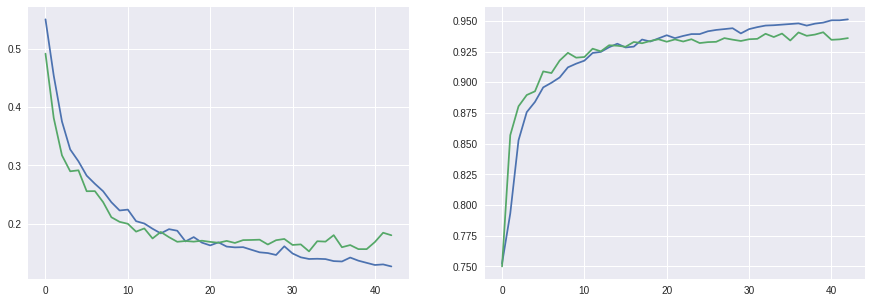

In [59]:
#plot validation & validation losses
fig, (loss, acc) = plt.subplots(1, 2, figsize=(15,5))
loss.plot(history.epoch,history.history['loss'],label='loss')
loss.plot(history.epoch,history.history['val_loss'],label='val_loss')
acc.plot(history.epoch,history.history['acc'],label='accuracy')
acc.plot(history.epoch,history.history['val_acc'],label='val_acc')
plt.show()


In [0]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


In [0]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [0]:
test_data_path = os.path.join(raw_data_path,'test')
test_img_path = os.path.join(test_data_path,'images')
test_fileIds = [x[:-4] for x in os.listdir(test_img_path)]

train_images_path = os.path.join(raw_data_path,'test','images')
test_data = [convertImage2Array(imgname,train_images_path) for imgname in test_fileIds]
test_data = np.array(test_data).reshape(-1,128,128,1)

In [0]:
model = tf.keras.models.load_model("./keras.model")
predicted_value = model.predict(test_data)

In [0]:
def resizeimagetoOri(img):
  return resize(img, (101, 101), mode='constant', preserve_range=True)


pre_dict = {idx:RLenc(np.round(resizeimagetoOri(predicted_value[i]))) for i,idx in enumerate(test_fileIds)}


In [0]:
#RLenc(resizeimage(np.round(predicted_value[0]),101))
sub = pd.DataFrame.from_dict(pre_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('./submission.csv')

files.download('./submission.csv')

In [0]:
resize(temp,[101,101])